In [1]:
import torch
from diffusers import StableDiffusionPipeline
from diffusers import utils
from diffusers import UNet2DConditionModel
from diffusers import AudioLDMPipeline
from diffusers import DDIMScheduler
from torchvision.utils import save_image
import csv
import IPython.display as ipd

import matplotlib.pyplot as plt
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np
import argparse, os, sys, datetime, glob, importlib, csv
import math

sys.path.append(os.getcwd())
# import cv2
import torchaudio
import torchaudio.transforms as transforms
import time
from encodec import EncodecModel
from encodec.utils import convert_audio
import torch.nn.functional as F
from transformers import AutoTokenizer, T5EncoderModel,T5TokenizerFast
from torchsummary import summary
from IPython.display import FileLink



In [2]:
channel_means = [  2.2741,  11.2872,  -3.3938,  -1.5556,  -0.0302,   7.6089,  -5.5797,
          0.2140,  -0.3536,   6.0188,   1.8582,  -0.1103,   2.2026,  -7.0081,
         -0.0721,  -8.7742,  -2.4182,   4.4447,  -0.2184,  -0.5209, -11.9494,
         -4.0776,  -1.4555,  -1.6505,   6.4522,   0.0997,  10.4067,  -3.9268,
         -7.0161,  -3.1253,  -8.5145,   3.1156,   2.2279,  -5.2728,   2.8541,
         -3.3980,  -1.1775,  -9.7662,   0.3048,   3.8765,   4.5021,   2.6239,
         14.1057,   3.2852,   1.9702,  -1.6345,  -4.3733,   3.8198,   1.1421,
         -4.4388,  -5.3498,  -6.6044,  -0.4426,   2.8000,  -7.0858,   2.4989,
         -1.4915,  -6.1275,  -3.0896,   1.1227,  -8.7984,  -4.9831,  -0.3888,
         -3.1017,  -7.5745,  -2.4760,   1.0540,  -2.5350,   0.0999,   0.6126,
         -1.2301,  -5.8328,  -0.7275,  -1.2316,  -2.2532, -11.5017,   0.9166,
         -2.2268,  -2.8496,  -0.5093,  -0.3037,  -6.3689,  -9.5225,   4.5965,
          3.1329,  -1.8315,   5.3135,  -3.8361,   1.6335,  -0.1705,  11.0513,
          5.3907,  -0.2660,   4.6109,  -8.9019,   6.5515,   0.8596,  16.6196,
         -0.7732,   4.1237,   2.9267,   9.9652,   4.6615,   1.4660,  -9.7225,
         -1.5841,  -0.5714,  -4.3343,  -0.1914,   2.8624, -11.2139,  -2.5840,
         -6.7120,   0.2601,  -5.4195,   0.3554,   3.0438,  -1.0295,   1.3360,
         -4.1767,   0.6468,   1.8145,   1.7140,   3.0185,   0.4881,   0.5796,
         -2.4755,   2.6202]
channel_stds = [1.7524, 1.2040, 1.1098, 1.1021, 1.3688, 1.1374, 1.8660, 0.9791, 1.4331,
        1.7740, 1.2690, 1.0297, 0.9953, 1.5363, 1.2166, 1.6564, 1.4858, 1.2349,
        1.5086, 1.0814, 1.4421, 0.9258, 0.9343, 1.2007, 1.3848, 1.2732, 1.7759,
        1.3544, 1.4707, 1.2685, 1.7004, 1.2947, 1.2967, 1.8925, 0.9231, 0.7637,
        1.3777, 1.6680, 0.9658, 0.9257, 0.5259, 0.9949, 1.7375, 1.0734, 1.2916,
        0.8570, 0.6263, 0.9911, 0.9574, 0.9979, 1.5969, 1.1886, 1.1147, 1.2280,
        2.0169, 1.1813, 1.2589, 1.1162, 1.3689, 1.2516, 1.2139, 1.0343, 1.1895,
        1.1726, 1.1923, 1.2714, 1.0043, 0.6465, 1.3860, 1.4449, 0.9567, 1.0218,
        0.9560, 1.4757, 1.0544, 0.8112, 1.4364, 1.0843, 1.2569, 1.0138, 1.1886,
        0.8627, 1.1016, 1.4231, 1.3607, 1.1215, 1.9759, 1.5381, 0.9219, 0.8572,
        0.6288, 0.8029, 1.1699, 1.1962, 1.5783, 0.9037, 1.2214, 2.0878, 1.3015,
        1.2254, 1.2898, 1.5421, 1.2834, 1.7237, 1.3471, 0.8689, 1.2807, 1.2174,
        1.2048, 0.6644, 1.5379, 1.4997, 0.7932, 0.7638, 0.8680, 1.3108, 1.8261,
        1.3964, 1.2147, 1.1391, 1.0011, 1.5988, 1.5721, 1.0963, 1.4303, 1.3737,
        1.5043, 1.3079]


def show_split_img(image, title=None):
    # Split the image in half horizontally
    height, width = image.shape
    half_width = width // 2
    left_half = image[:, :half_width]
    right_half = image[:, half_width:]

    # Create the subplots and plot the left and right halves of the image
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16, 2))
    axs[0].imshow(left_half)
    axs[1].imshow(right_half)

    # Hide the x and y axis ticks and labels for a cleaner plot
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Show the plot
    # if (title):
    #     axs[0].title(title)
    plt.show()

    
def rescale(image):
    image = torch.Tensor.view(image, [128, 24, 21]).clone()
    mean_v = torch.tensor(channel_means)
    std_v =torch.tensor(channel_stds)
    image = image * std_v.view(-1,1,1) + mean_v.view(-1,1,1)
    
    # for row, mean, std in zip(image, channel_means, channel_stds):
    #     row *= std 
    #     row += mean
    
    image = torch.Tensor.view(image, [1, 128, 504])
    return image

def visualize_channels(img):
    test_img = img.clone()
    test_img = torch.Tensor.view(test_img, [128, 24, 21])
    fig, axs = plt.subplots(8, 16, figsize=(12, 12))
    for ax, layer in zip(axs.flatten(), test_img):
        ax.imshow(layer.cpu().numpy())
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])


In [3]:
model_path = "/u/li19/data_folder/model_cache/audio_journey_clap"
device = "cuda"
# model_path = "CompVis/stable-diffusion-v1-4"




In [4]:
pipe = StableDiffusionPipeline.from_pretrained(
    model_path,
    device_map=None, 
    safety_checker=None,
    low_cpu_mem_usage=False)

pipe.to(device)
pipe.vae_scale_factor = 1



Some weights of the model checkpoint at /u/li19/data_folder/model_cache/audio_journey_clap/unet were not used when initializing UNet2DConditionModel: ['encoder_hid_proj.weight', 'encoder_hid_proj.bias']
- This IS expected if you are initializing UNet2DConditionModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing UNet2DConditionModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/u/li19/data_folder/anaconda3/envs/diffuse/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety

In [5]:
# print(pipe.unet.up_blocks)
for layer in pipe.unet.down_blocks:
    is_frozen = all(param.requires_grad == False for param in layer.parameters())
    print(is_frozen)
    # for param in layer.parameters():
    #     print(param.requires_grad)

False
False
False
False


In [6]:
# tokenizer = AutoTokenizer.from_pretrained("t5-large", model_max_length=512)
# text_encoder = T5EncoderModel.from_pretrained("t5-large")


In [7]:
tokenizer = AutoTokenizer.from_pretrained("cvssp/audioldm-m-full", model_max_length=512,  subfolder="tokenizer")
text_encoder = T5EncoderModel.from_pretrained("cvssp/audioldm-m-full", subfolder="text_encoder")

# === Fix for using masking on text encoder ===

text_encoder.config.use_attention_mask = False


You are using a model of type clap_text_model to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at cvssp/audioldm-m-full were not used when initializing T5EncoderModel: ['text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.5.attention.output.dense.weight', 'text_model.encoder.layer.4.intermediate.dense.bias', 'text_model.encoder.layer.0.intermediate.dense.bias', 'text_model.embeddings.position_embeddings.weight', 'text_model.encoder.layer.4.attention.self.query.bias', 'text_model.encoder.layer.8.attention.self.query.bias', 'text_model.encoder.layer.2.output.dense.weight', 'text_model.encoder.layer.2.intermediate.dense.weight', 'text_model.encoder.layer.3.attention.self.value.bias', 'text_model.encoder.layer.10.attention.self.query.weight', 'text_model.encoder.layer.1.intermediate.dense.weight', 'text_model.encoder.layer.11.attention.self.query.weight', 'text

In [8]:
print(hasattr(text_encoder.config, "use_attention_mask") and text_encoder.config.use_attention_mask)

False


In [9]:
pipe.tokenizer = tokenizer
pipe.text_encoder = text_encoder.to(device)

In [10]:
model = EncodecModel.encodec_model_24khz()
model.set_target_bandwidth(6.0)
model = model.to(device)
# pipe.vae = model

In [16]:

conf = "/u/li19/data_folder/testing/audio_journey_128_clap_scratch/checkpoint-12000/unet/"

new_unet = UNet2DConditionModel.from_pretrained(conf)
new_unet.to(device)
pipe.unet = new_unet



In [17]:
noise_scheduler = DDIMScheduler.from_pretrained("/u/li19/data_folder/model_cache/audio_journey_128_ddim_2", subfolder="scheduler")
pipe.scheduler = noise_scheduler

In [18]:
# conv_in = pipe.unet.conv_in.to("cpu")
# conv_out = pipe.unet.conv_out.to("cpu")
# i_weights = conv_in.weight
# o_weights = conv_out.weight
# print(f'INPUT: mean {i_weights.mean()} -- std {i_weights.std()}')
# print(f'OUTPUT: mean {o_weights.mean()} -- std {o_weights.std()}')


# num_parameters_in = (conv_in.in_channels *
#                   conv_in.kernel_size[0] *
#                   conv_in.kernel_size[1] *
#                   conv_in.out_channels) + conv_in.out_channels

# num_parameters_out = (conv_out.in_channels *
#                   conv_out.kernel_size[0] *
#                   conv_out.kernel_size[1] *
#                   conv_out.out_channels) + conv_out.out_channels

# print(f'INPUT: mean {num_parameters_in}')
# print(f'OUTPUT: mean {num_parameters_out}')
# print()
# print(conv_in.activation_fn)
# print(conv_out.activation_fn)

# INPUT: mean 0.00018122552137356251 -- std 0.06583860516548157
# OUTPUT: mean -5.646047429763712e-05 -- std 0.034161750227212906

In [19]:
# pipe.scheduler.num_train_timesteps=40
# print(pipe.scheduler)8

In [83]:
prompts = ["sound of a person speaking while a car passes",
          # "a dog howling",
          "sound a dog barking",
          # #  "Speech, Singing, and Yodeling",
          #  "sound of A Hammer striking metal",
            "A Hammer striking wood",
           "sound of Brass instrument, and Saxophone, and jazz"
          ]



imgs = [pipe(prompt=p, width=504, height=128, num_inference_steps=30,guidance_scale=1, output_type="latent").images[0] for p in prompts]






# print(imgs[0].mean())
# print(imgs[0].std())



attention Mask:None


  0%|          | 0/30 [00:00<?, ?it/s]

Noise Mean: tensor([-2.8411e-02,  3.7290e-03,  1.3787e-01,  4.3921e-02, -1.2687e-02,
        -2.8741e-02, -1.4411e-02, -9.3626e-02,  9.3495e-02,  1.2750e-02,
         6.8613e-02, -4.0657e-02,  9.1644e-02, -2.7026e-02, -3.1364e-02,
        -3.8285e-02, -3.8634e-02,  6.3307e-02,  3.4333e-02,  2.7546e-03,
         1.1264e-01,  6.7569e-02, -3.3747e-02, -3.8539e-02, -1.2590e-02,
        -8.5517e-04,  1.3865e-02, -6.1090e-03, -1.1611e-02, -1.2172e-02,
        -1.9708e-02,  4.3275e-03,  4.4165e-03,  1.7180e-03, -1.0103e-01,
        -1.8962e-03,  2.1830e-03, -5.8431e-02,  1.5580e-01,  2.5919e-02,
        -7.9571e-02, -8.2237e-02,  1.4705e-01, -3.3028e-02, -9.5015e-02,
         5.3092e-02, -7.0255e-03,  7.0995e-02, -5.8529e-02,  2.2590e-02,
        -2.0329e-02, -1.9102e-02,  6.9399e-02, -7.8952e-02, -1.0203e-01,
        -2.9752e-02,  5.5562e-02,  1.9450e-02, -2.3118e-02, -7.2572e-02,
        -1.4413e-02, -3.6877e-02, -2.5740e-02, -3.9021e-02, -4.1426e-02,
         1.5004e-02, -7.7727e-02, -7.23

  0%|          | 0/30 [00:00<?, ?it/s]

Noise Mean: tensor([-0.0222,  0.0389,  0.0798,  0.0460, -0.0341, -0.0258,  0.0033, -0.0478,
         0.1566,  0.0208,  0.0497, -0.0752,  0.0801, -0.0207,  0.0159, -0.0044,
         0.0012, -0.0100,  0.0179,  0.0257,  0.0664,  0.1163, -0.0150, -0.0406,
         0.0183, -0.0461,  0.1003, -0.0195,  0.0144,  0.0621, -0.0019,  0.0504,
        -0.0149,  0.0132, -0.1567, -0.0238,  0.1252, -0.0218,  0.0762,  0.0271,
        -0.0542, -0.0342,  0.0898,  0.0038, -0.1116,  0.0521, -0.0139,  0.0459,
        -0.0210, -0.0119,  0.0192, -0.0616,  0.0544,  0.0216, -0.1287,  0.0440,
         0.0579,  0.0623, -0.0725, -0.0751,  0.0258,  0.0136, -0.0027, -0.0091,
        -0.0397,  0.0338, -0.0307, -0.0861,  0.0898, -0.0269, -0.0239,  0.0756,
        -0.0333,  0.0393,  0.0152,  0.0592,  0.0496,  0.0065, -0.0189, -0.0093,
         0.0249,  0.0006,  0.0031,  0.0239, -0.0302, -0.0303,  0.0251,  0.0291,
         0.0038, -0.0780, -0.0496, -0.0709,  0.1644,  0.0672,  0.0278, -0.0040,
         0.0004, -0.0013,  0

  0%|          | 0/30 [00:00<?, ?it/s]

Noise Mean: tensor([-3.1758e-03,  3.5818e-05,  8.3850e-02,  1.9743e-02, -2.6568e-02,
        -5.4382e-02, -3.3653e-02, -1.9390e-03,  1.4573e-01,  1.8582e-02,
         6.0726e-02, -7.0984e-02,  7.1353e-02, -1.7434e-02, -2.5702e-02,
        -1.6793e-02, -2.8347e-02,  7.4647e-02, -4.3225e-02,  4.2855e-02,
        -4.5722e-03,  6.9867e-02, -3.3604e-02, -1.1403e-01, -7.7969e-03,
        -2.1229e-02,  5.1494e-02, -1.0383e-02,  1.0002e-02,  1.9559e-02,
        -1.2646e-02,  3.5421e-02,  2.3530e-02, -2.5920e-02, -1.3197e-01,
         1.5570e-02,  4.3289e-02, -4.6390e-02,  1.5691e-01,  1.0328e-02,
        -2.8055e-02, -9.0495e-02,  5.1494e-02, -1.2912e-02, -5.4870e-02,
         5.2549e-02,  1.0457e-02,  4.5251e-02, -4.9682e-02,  3.9884e-02,
         1.9582e-02, -3.4253e-03,  4.4164e-02, -5.8746e-02, -6.8845e-02,
        -1.6589e-02,  8.2756e-02, -4.8725e-02,  1.0260e-03, -7.3566e-02,
         1.1261e-02, -1.2614e-02,  4.7599e-03, -1.5493e-02,  1.2168e-02,
         4.6228e-02, -2.3612e-03, -3.74

  0%|          | 0/30 [00:00<?, ?it/s]

Noise Mean: tensor([-0.0672,  0.1079,  0.1157,  0.0889,  0.0557, -0.0394, -0.0177, -0.0128,
         0.1554,  0.0278,  0.0864, -0.0870, -0.0075, -0.0349,  0.0378, -0.0143,
        -0.0426,  0.0061,  0.0426,  0.0600,  0.0512,  0.0802, -0.0630,  0.0396,
        -0.0192, -0.0533,  0.0188, -0.0179, -0.0482, -0.0253,  0.0009,  0.0175,
        -0.0170,  0.0124, -0.1561, -0.0010, -0.0044, -0.0338,  0.1235,  0.0090,
         0.0092, -0.0651,  0.0397, -0.0331, -0.0892, -0.0049, -0.0117,  0.0880,
         0.0309,  0.0166,  0.0017, -0.0346,  0.0471, -0.0354, -0.0755,  0.0345,
         0.0642,  0.0562, -0.0466, -0.0858,  0.0956, -0.0649, -0.0078,  0.0093,
        -0.0118,  0.0328, -0.0142, -0.0142,  0.0590, -0.0345, -0.0480,  0.0727,
        -0.0174,  0.0317,  0.0129, -0.0355, -0.0232, -0.0567, -0.0026, -0.0050,
         0.0909, -0.0170, -0.0719,  0.1092,  0.0235, -0.0382,  0.0457,  0.0114,
        -0.0538, -0.0569,  0.0008,  0.0357,  0.0495,  0.0136,  0.0184, -0.0233,
         0.0525, -0.0279,  0

In [84]:
print(pipe.scheduler)

DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.15.1",
  "beta_end": 0.0195,
  "beta_schedule": "squaredcos_cap_v2",
  "beta_start": 0.0015,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 1,
  "thresholding": false,
  "trained_betas": null
}



In [85]:
print(imgs[0].shape)

torch.Size([1, 128, 504])


In [86]:
norm_imgs = [rescale(img[0].detach().cpu()) for img in imgs]
# d_imgs = [imgs[i].detach().cpu() - norm_imgs[i] for i in range(len(prompts))]

sound of a person speaking while a car passes


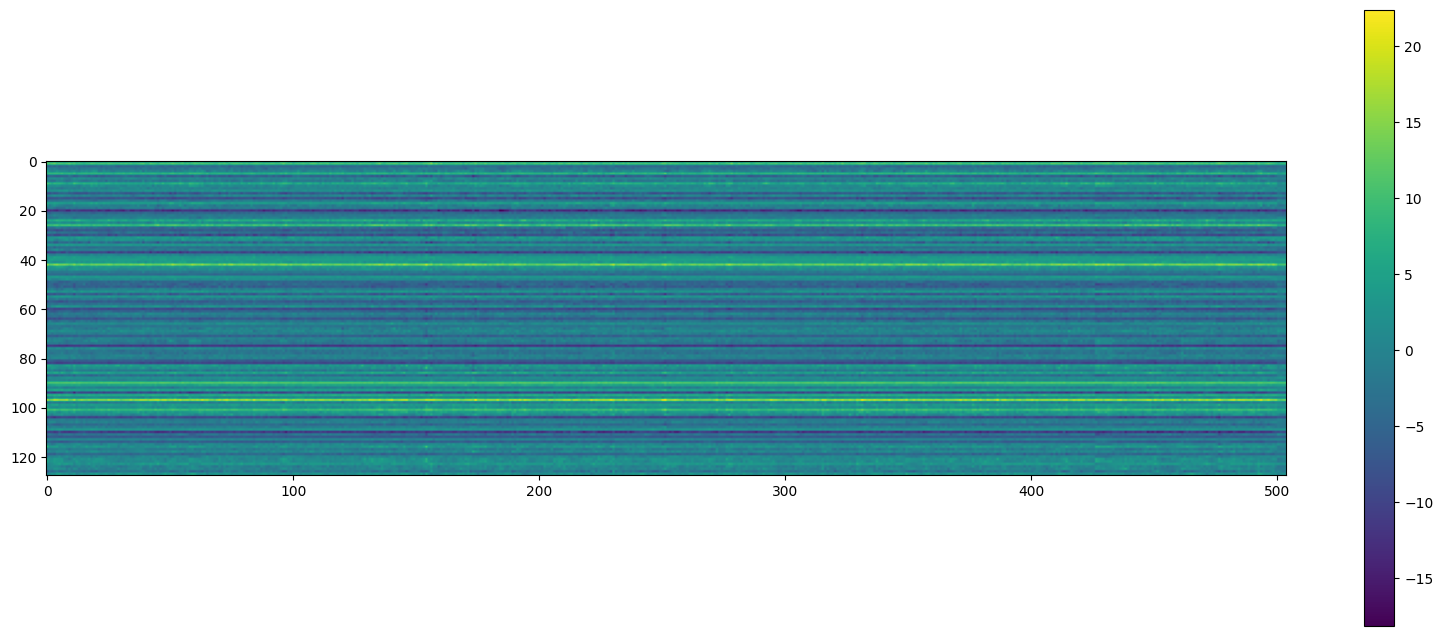

/u/li19/diffusers_with_dataloader/notebooks/imgs/simple_plotsound of a person speaking while a car passes.png

sound a dog barking


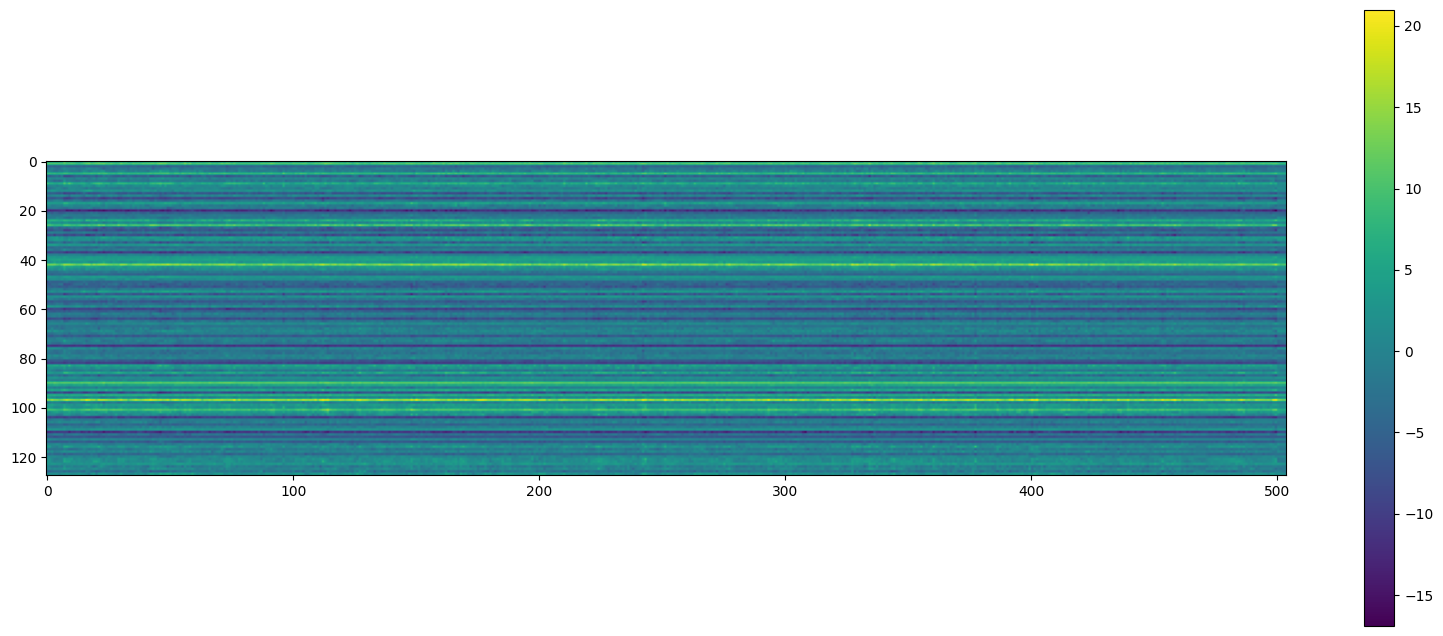

/u/li19/diffusers_with_dataloader/notebooks/imgs/simple_plotsound a dog barking.png

A Hammer striking wood


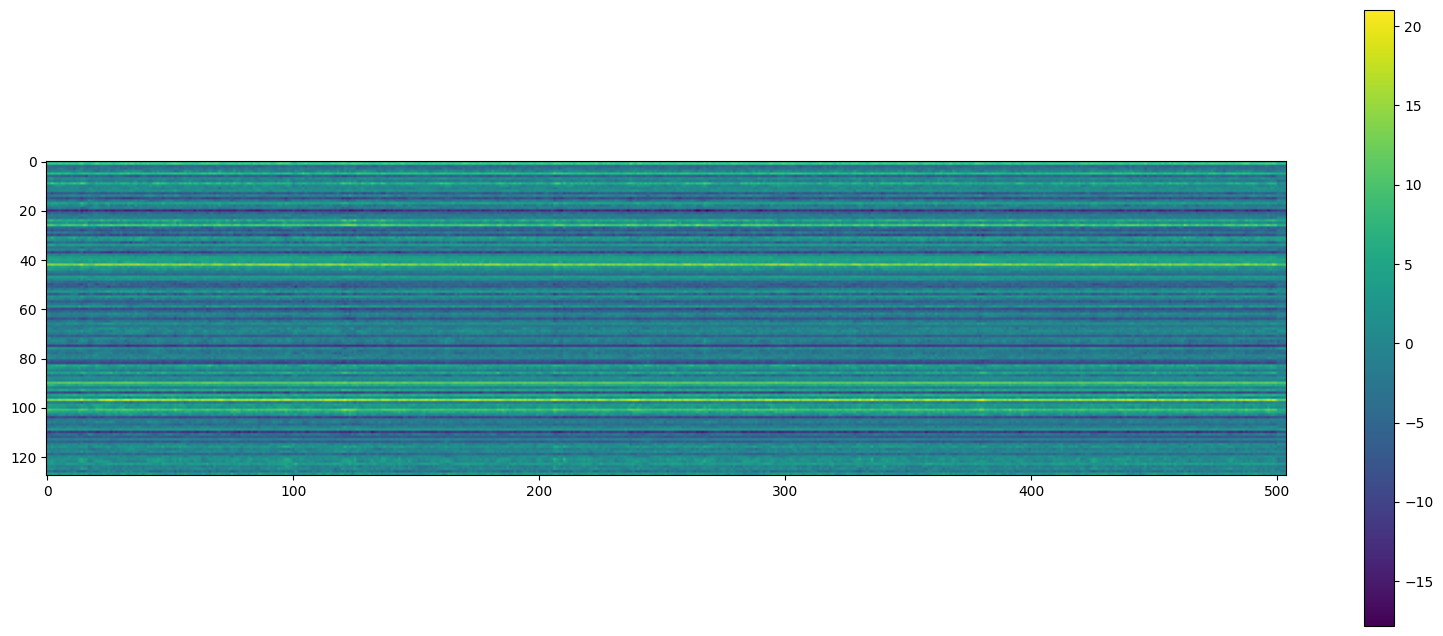

/u/li19/diffusers_with_dataloader/notebooks/imgs/simple_plotA Hammer striking wood.png

sound of Brass instrument, and Saxophone, and jazz


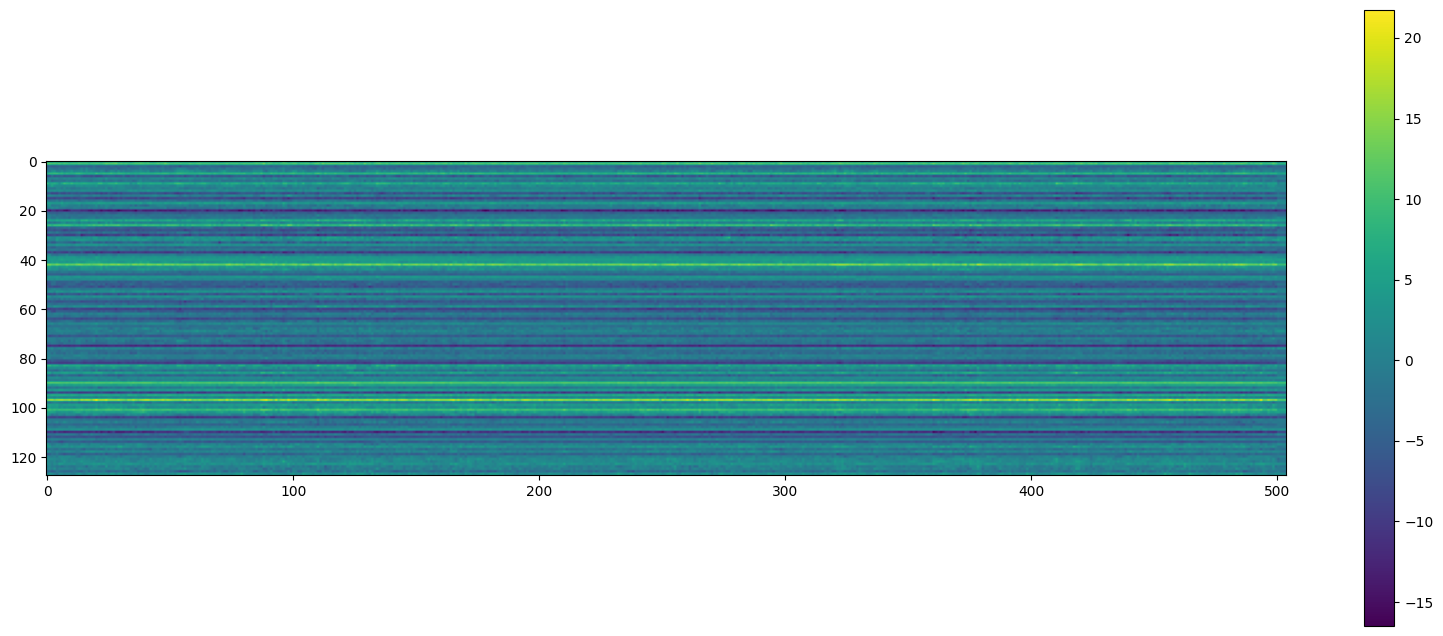

/u/li19/diffusers_with_dataloader/notebooks/imgs/simple_plotsound of Brass instrument, and Saxophone, and jazz.png

In [87]:

# print("================================MULTI PROMPT================================")
for img, cap in zip(norm_imgs, prompts):
    print(cap)
    plt.figure(figsize=(20,8))
    plt.imshow(img[0].cpu().numpy())
    filename = f'imgs/simple_plot{cap}.png'

    plt.savefig(filename)

    plt.colorbar()
    plt.show()
    display(FileLink(filename))

    
# for img, cap in zip(imgs, prompts):
#     print(cap)
#     plt.figure(figsize=(20,8))
#     plt.imshow(img[0].cpu().numpy())

#     plt.colorbar()
#     plt.show()
    # show_split_img(img[0,:,:].cpu())

In [88]:




for vanilla in imgs:
    img = torch.Tensor.view(vanilla.clone(), [128, 24, 21])
    means = img.mean(axis=(1,2))
    stds = img.std(axis=(1,2))
    
    print(f'MEAN: mean {means.mean()} -- std {means.std()}')
    print(f'STD: mean {stds.mean()} -- std {stds.std()}')
    print()
#     print(means.mean())
#     print(stds)


MEAN: mean -0.028822889551520348 -- std 0.3335198163986206
STD: mean 0.909543514251709 -- std 0.10060989856719971

MEAN: mean -0.052085332572460175 -- std 0.371940940618515
STD: mean 0.8907904624938965 -- std 0.0805557519197464

MEAN: mean -0.05174962431192398 -- std 0.41876527667045593
STD: mean 0.935303807258606 -- std 0.10602690279483795

MEAN: mean -0.06785724312067032 -- std 0.33333197236061096
STD: mean 0.8754832148551941 -- std 0.10294092446565628



In [89]:
for scaled, vanilla in zip(norm_imgs, imgs):
    print("======= STATS =======")
    print(f'Scaled - Mean {scaled.mean()} : STD: {scaled.std()}')
    print(f'Vanilla - Mean {vanilla.mean()} : STD: {vanilla.std()}')

======= STATS =======
Scaled - Mean -0.5485001802444458 : STD: 5.103604316711426
Vanilla - Mean -0.0288228876888752 : STD: 0.9726420044898987
======= STATS =======
Scaled - Mean -0.5657578110694885 : STD: 5.02069091796875
Vanilla - Mean -0.05208534002304077 : STD: 0.9672810435295105
======= STATS =======
Scaled - Mean -0.5744209885597229 : STD: 5.163665771484375
Vanilla - Mean -0.05174963176250458 : STD: 1.0286884307861328
======= STATS =======
Scaled - Mean -0.5928393006324768 : STD: 5.064608097076416
Vanilla - Mean -0.06785724312067032 : STD: 0.9411158561706543


In [90]:
mean = -0.50601
std = 5.22701

idx =3

img = np.copy(norm_imgs[idx].cpu())


print(img.mean())
print(img.std())


# img /= std
# img += mean

print("==== POST SCALE ====")
print(img.mean())
print(img.std())


quantized = model.quantizer(torch.from_numpy(img).to(device), model.frame_rate).quantized

print(img.shape)
t_img = torch.from_numpy(img).to(device)
output = model.decoder(t_img)
output_2 = model.decoder(quantized)

-0.5928393
5.0645685
==== POST SCALE ====
-0.5928393
5.0645685
(1, 128, 504)


In [91]:
print(output.shape)

torch.Size([1, 1, 161280])


sound of Brass instrument, and Saxophone, and jazz


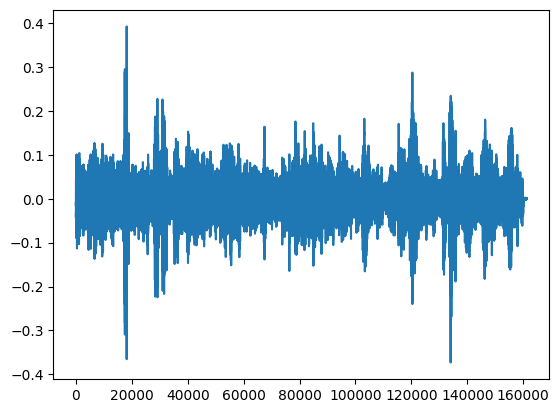

In [92]:
final = output[0][0].detach().cpu().numpy()

print(prompts[idx])

plt.plot(final)
ipd.Audio(final, rate=16000)

In [93]:


# t_img = torch.from_numpy(img).to("cuda")
# quantized = model.quantizer.encode(t_img, model.frame_rate, model.bandwidth)
# print(quantized.shape)
# # plt.imshow(quantized.cpu().numpy())
# decode = model.quantizer.decode(quantized)
# print(decode.shape)
# plt.imshow(decode[0].cpu().numpy())

In [94]:
n_fft = 4096
win_length = 1024
hop_length = 400
n_mels = 64
sample_rate = 16000

waveform = torch.from_numpy(np.copy(final)[None, :])

print(waveform.shape)

mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="constant",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="slaney",
)

mel_spectrogram = mel_spectrogram_transform(waveform)
amplitude_to_db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=88)
log_mel_spectrogram_db = amplitude_to_db_transform(mel_spectrogram)
# log_mel_spectrogram_db = log_mel_spectrogram_db.transpose(0,1)

torch.Size([1, 161280])


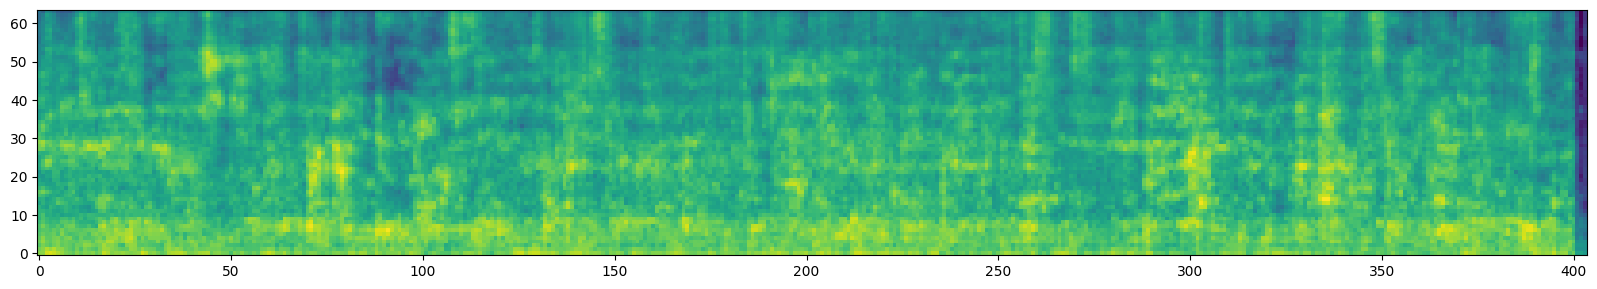

In [95]:
# Set the figure size
fig= plt.figure(figsize=(20, 10))
# Show the image
plt.imshow(log_mel_spectrogram_db[0], origin='lower')

# Display the plot
plt.show()

